In [1]:
# Imports

from datetime import datetime, timedelta

from sklearn.utils import shuffle
import numpy as np
import os

import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Options

stocks = ['AMD', 'GOOG', 'MSFT', 'AAPL']

max_length = 80
vocab_size = 600
emb_size   = 100

epochs     = 120
batch_size = 64

In [3]:

def get_tick_data(stocks):
    """
    Tick Data
    
    This reads the high, lows, closes, etc. from data csv files
    """
    history = {}
    
    for stock in stocks:
        
        history[stock] = {}
        
        with open(os.path.join('..', 'data', stock + '.csv'), 'r') as data:

            for line in data:

                if len(line) > 6 and "Date" not in line and "null" not in line:

                    items = line.split(",")
                    
                    date = items[0]
                    data = np.array(list(map(float, items[1:]))) # 0, 1, 2, 4, 5 -> OPEN HIGH LOW ADJ_CLOSE VOLUME
                    
                    history[stock][date] = data
        
    return history


In [4]:

def get_headline_data(stocks):
    """
    Headline Data
    
    This reads the headlines from the headline csv file (created by CollectData)
    """
    history = {}
    
    with open(os.path.join('..', 'data', "_".join(stocks) + '-headlines.csv'), 'r', encoding="utf8") as data:
        
        for line in data:

            if len(line) > 6:

                stock, date, headlines = line.split(",")
                
                headlines = eval(headlines.strip().replace('@', ','))
        
                if not stock in history:
                    
                    history[stock] = {}
                
                history[stock][date] = headlines
                
    return history


In [5]:

def make_headline_to_effect_data(tick_data, head_data):
    """
    Headline -> Effect
    
    Creates essentially the X, Y data for the embedding model to use
    when analyzing/encoding headlines. Returns a list of headlines and
    a list of corresponding 'effects' which represent a change in the stock price.
    """
    all_headlines, effects = [], []
    
    for stock, dates in head_data.items():
        
        for date, headlines in dates.items():
            
            ## Find Matching tick data dates for headline dates ##
            
            event_date = datetime.strptime(date, '%Y-%m-%d') # The date `of` headline
            effect_date = event_date + timedelta(days=1)     # The day after `affected` by headline
            
            for i in range(3):
                if event_date.strftime('%Y-%m-%d') in tick_data[stock]:
                    break
                else:
                    event_date -= timedelta(days=1)
            else:
                continue
                    
            for i in range(2):
                if effect_date.strftime('%Y-%m-%d') in tick_data[stock]:
                    break
                else:
                    effect_date += timedelta(days=1)
            else:
                continue
                
            event_date = event_date.strftime('%Y-%m-%d')
            effect_date = effect_date.strftime('%Y-%m-%d')
            
            ## Determine Effect ##
            
            if event_date in tick_data[stock] and effect_date in tick_data[stock]:
                
                tick_on = tick_data[stock][event_date]
                tick_after = tick_data[stock][effect_date]
                
                if tick_after[3] >= tick_on[3]: # Compare Close Prices
                    
                    effect = [1., 0.]
                    
                else:
                    
                    effect = [0., 1.]
                    
                for source, headline in headlines.items():
                    
                    all_headlines.append(headline)
                    effects.append(effect)
                
    return all_headlines, np.array(effects)


In [6]:

def encode_sentences(sentences, tokenizer=None, max_length=100, vocab_size=100):
    """
    Encoder
    
    Takes a list of headlines and converts them into vectors
    """
    if not tokenizer:
        
        tokenizer = Tokenizer(num_words=vocab_size)
    
        tokenizer.fit_on_texts(sentences)
    
    encoded_headlines = tokenizer.texts_to_sequences(sentences)
    
    padded_headlines = pad_sequences(encoded_headlines, maxlen=max_length, padding='post')
    
    return padded_headlines, tokenizer


In [7]:

def split_data(X, Y, ratio, mix=True):
    """
    Splits X/Y to Train/Test
    """
    
    if mix:
        
        X, Y = shuffle(X, Y)
        
    train_size = int(len(X) * ratio)
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]
    
    return trainX, trainY, testX, testY


In [8]:

def get_model():
    
    model = Sequential()
    
    model.add(Embedding(vocab_size, emb_size, input_length=max_length))
    
    model.add(LSTM(200))
    model.add(Activation('selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(200))
    model.add(Activation('selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(200))
    model.add(Activation('selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(100))
    model.add(Activation('selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [9]:

if __name__ == "__main__":
    
    tick_data = get_tick_data(stocks)
    head_data = get_headline_data(stocks)
    
    headlines, effects = make_headline_to_effect_data(tick_data, head_data)
    
    encoded_headlines, toke = encode_sentences(headlines, max_length=max_length, vocab_size=vocab_size)
    
    trainX, trainY, testX, testY = split_data(encoded_headlines, effects, .8)
    
    print(trainX.shape, testY.shape)


(2608, 80) (652, 2)


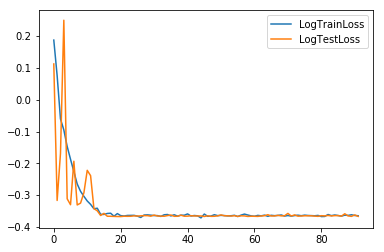

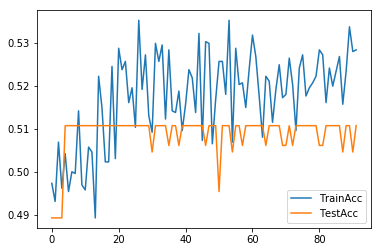

In [10]:

if __name__ == "__main__":
    
    model = get_model()
    
    e_stopping = EarlyStopping(monitor='val_loss', patience=70)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines.h5'), 
                                 monitor='val_acc',
                                 verbose=0,
                                 save_best_only=True)
    
    history = model.fit(trainX,
                        trainY,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(testX, testY),
                        verbose=0,
                        callbacks=[e_stopping, checkpoint])
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    

In [ ]:

if __name__ == "__main__":
    
    model = load_model(os.path.join('..', 'models', 'media-headlines.h5'))
    
    test_sents = [
        'the ceo of apple was fired after buying an android phone', 
        'amd just released a magical gpu thats better than every other company',
        'googles selfdriving car killed a family of ducks in a sensor malfunction',
        'the microsoft vr team released a breakthrough in virtual cooking'
    ]
    
    test_encoded, _ = encode_sentences(test_sents, tokenizer=toke, max_length=max_length, vocab_size=vocab_size)
    
    predictions = model.predict(test_encoded)
    
    for i in range(len(test_sents)):
        
        print("")
        print(test_sents[i])
        print(predictions[i])
        print("Stock Will Go Up" if np.argmax(predictions[i]) == 0 else "Stock Will Go Down")
